In [7]:
# Initial imports
import os
from pathlib import Path
import requests
import csv
import json
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json
import datetime as dt
import locale


locale.setlocale( locale.LC_ALL, '' )
print(Path.cwd())


def get_input_file_path():
    inputPath = input('Enter the path & file name that you wish to read from:')
    return inputPath

def get_data_table(data_path,index_column,csv=True,panda=True,api=None,jsonFlag=True,datetime_format=True,parse_dates=True,dateFormat=None,sort=True,dropNulls=True):
    if csv==True and panda!=True:
        with open(csvPath,'r') as csvFile:
            csvReader = csv.reader(csvFile,delimiter = ',')
            print(type(csvReader))
            #defining Parameters
            header = next(csvReader)
        return csvReader
    elif panda==True and api!=True:
        if csv==True:
            df = pd.read_csv(data_path, index_col=index_column, infer_datetime_format=datetime_format, parse_dates=parse_dates)
        if dateFormat != None:
            df.index = pd.to_datetime(df.index, format=dateFormat)
        if sort:
            df.sort_index(inplace=True)
        if dropNulls:
            df.dropna(inplace=True)
        return df
    elif api==True and panda!= True:
        if jsonFlag:
            data_path = data_path + "?format=json"
            data = requests.get(btc_url)
            data_table = data.json()
        else:
            data_table = requests.get(btc_url)
        
        return data_table
        
        
def setOutputPath():
    outputPath = input('Enter the path & file name that you wish to output to:')
    return outputPath

def writeCsvPath(outputPath,data=None,header=True):
    # Set the output header
    header = ["Net_Total","Number_of_Months","Min_Profit_Loss","Max_Profit_Loss","Average_Profit_Loss"]

    # Set the output file path
    output = Path(outputPath)

    # Open the output path as a file object
    with open(output,'w') as csvfile:
        # Set the file object as a csvwriter object
        csvwriter = csv.writer(csvfile, delimiter=',')
        # Write the header to the output file
        if header == True:
            csvwriter.writerow(header)
        # Write the list of dictionary items to the output file
        csvwriter.writerow(data.items())
        
def combine_data_tables(dataList,join,axis='columns',printData=None,sortData=None):
    
    combined_df = pd.concat(dataList,axis=axis,join=join)
    if sortData:
        combined_df.sort_index(inplace=True)
    if printData:
        combined_df.head()
    
    return combined_df

def get_daily_returns(data,drop_nulls=True,count_nulls=True):
    if isinstance(data,pd.DataFrame):
        daily_returns = data.pct_change()
        if count_nulls:
            print(daily_returns.isnull().sum())
        if drop_nulls:
            daily_returns.dropna(inplace=True)
            
        #Will put more code for reading csv files 
    else:
        daily_returns = None
    
    return daily_returns


def get_cumulative_returns(data):
    if isinstance(data,pd.DataFrame):
        cumulative_returns = (1 + data).cumprod() - 1
        
    else:
        cumulative_returns = None
        
    return cumulative_returns

def calculate_annual_std(data):
    if isinstance(data,pd.DataFrame):
        annual_std = combined_Daily_Returns_std * np.sqrt(252)
    else:
        annual_std = None
        
    return annual_std

def calculate_sharpe_ratio(dataframe):
    if isinstance(dataframe,pd.DataFrame):
        volatility = dataframe.std() * np.sqrt(252)
        sharpe_ratio = (dataframe.mean() * 252)/ volatility
        
    else:
        sharpe_ratio = None
    
    return sharpe_ratio

%matplotlib inline

/Users/torylbrown/Desktop/Fintech/python-homework/API_Financial_Planner5/Starter_Code


In [8]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [9]:
# Set current amount of crypto assets
crypto_tickers = ['BTC','ETH']
avg_household_income = 12000.00
my_btc= 1.2
my_eth = 5.3


In [10]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

33508.0

The current value of your 1.2 BTC is $40209.60
The current value of your 5.3 ETH is $177592.40


In [12]:
# Fetch current BTC price
btc_json_data = get_data_table(btc_url,index_column=None,csv=None,panda=False,api=True,jsonFlag=True)
btc_level0 = list(btc_json_data.keys())[0]
btc_level1 = list(btc_json_data[btc_level0].keys())[0]
btc_price = btc_json_data[btc_level0][btc_level1]['quotes']['USD']['price']

# Fetch current ETH price
eth_json_data = get_data_table(eth_url,index_column=None,csv=None,panda=False,api=True,jsonFlag=True)
eth_level0 = list(eth_json_data.keys())[0]
eth_level1 = list(eth_json_data[eth_level0].keys())[0]
eth_price = eth_json_data[eth_level0][eth_level1]['quotes']['USD']['price']

# Compute current value of my crpto
my_btc_value = btc_price * my_btc
my_eth_value = eth_price * my_eth

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $41416.80
The current value of your 5.3 ETH is $182924.20


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [13]:
# Current amount of shares
my_spy = 50
my_agg = 200

In [15]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [17]:
# Format current date as ISO format
start_date = pd.Timestamp("2021-01-11", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
ticker_df = api.get_barset(
    tickers,
    timeframe,
    start=start_date
).df
#ticker_df.index = ticker_df.index.dt.date
ticker_df.reset_index(inplace=True)
ticker_df['time'] = ticker_df['time'].dt.date
#ticker_df['time'] = 'date'
ticker_df.set_index('time',inplace=True)
# Preview DataFrame

ticker_df.head()

AGG                                      SPY                    \
              open    high     low   close   volume    open    high       low   
time                                                                            
2021-01-11  117.02  117.05  116.89  116.89  5047096  377.85  380.58  377.7189   

                              
             close    volume  
time                          
2021-01-11  378.74  44814805

In [18]:
agg_close_price = ticker_df['AGG']['close']
print(agg_close_price[0])

116.89


In [19]:
# Pick AGG and SPY close prices
df_closing_prices = pd.DataFrame()
df_closing_prices["SPY"] = ticker_df['SPY']['close']
df_closing_prices["AGG"] = ticker_df['AGG']['close']
#df_closing_prices.index = df_closing_prices.index.date
spy_close_price = df_closing_prices['SPY'][0]
agg_close_price = df_closing_prices['AGG'][0]

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $116.89
Current SPY closing price: $378.74


In [20]:
# Compute the current value of shares
my_spy_value = my_spy * spy_close_price
my_agg_value = my_agg * agg_close_price

# Print current value of share
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $18937.00
The current value of your 200 AGG shares is $23378.00


### Savings Health Analysis

In [21]:
# Set monthly household income
monthly_income = 1200

# Create savings DataFrame
data = {'amount':[19385.986877,40616.50]} 
  
# Creates pandas DataFrame. 
df_savings = pd.DataFrame(data, index =['crypto','shares'])

# Display savings DataFrame
display(df_savings)

,amount
crypto,19385.986877
shares,40616.500000


<AxesSubplot:ylabel='amount'>

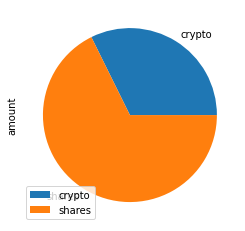

In [22]:
# Plot savings pie chart
df_savings.plot(kind='pie',y='amount')

In [24]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = round(df_savings.amount.sum(),2)
print(total_savings)

# Validate saving health
if total_savings > emergency_fund:
    message = 'Congratulations for having enough money in this fund!!'
elif total_savings == emergency_fund:
    message = 'Congratualtions for meeting your financial goal!'
else:
    message = 'You are $%f away from reaching your savings goal.'%round(emergency_fund - total_savings,2)

print(message)

60002.49
Congratulations for having enough money in this fund!!


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [27]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-01-11', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-01-11', tz='America/New_York').isoformat()

In [29]:
# Get 5 years' worth of historical data for SPY and AGG
tickers = ["AGG","SPY"]
df_stock_data = api.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

# Display sample data
df_stock_data.tail()

AGG                                        \
                             open      high       low    close   volume   
time                                                                      
2021-01-05 00:00:00-05:00  118.06  118.0600  117.7500  117.915  5915389   
2021-01-06 00:00:00-05:00  117.90  117.9000  117.1500  117.360  8587136   
2021-01-07 00:00:00-05:00  117.13  117.2600  117.0667  117.210  4949593   
2021-01-08 00:00:00-05:00  117.18  117.3428  116.9800  117.090  5580443   
2021-01-11 00:00:00-05:00  117.02  117.0500  116.8900  116.890  5047096   

                              SPY                                      
                             open    high       low   close    volume  
time                                                                   
2021-01-05 00:00:00-05:00  368.10  372.50  368.0500  371.32  53668865  
2021-01-06 00:00:00-05:00  369.71  376.98  369.1200  373.53  91989131  
2021-01-07 00:00:00-05:00  376.10  379.90  375.9100  379.06  58862006  
2021-01-08 00:00:00-05:00  380.59  381.49  377.1000  381.24  60275466  
2021-01-11 00:00:00-05:00  377.85  380.58  377.7189  378.74  44814805

In [30]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirtyyear = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [31]:
# Printing the simulation input data
MC_thirtyyear.portfolio_data.tail()

AGG                                        \
                             open      high       low    close   volume   
time                                                                      
2021-01-05 00:00:00-05:00  118.06  118.0600  117.7500  117.915  5915389   
2021-01-06 00:00:00-05:00  117.90  117.9000  117.1500  117.360  8587136   
2021-01-07 00:00:00-05:00  117.13  117.2600  117.0667  117.210  4949593   
2021-01-08 00:00:00-05:00  117.18  117.3428  116.9800  117.090  5580443   
2021-01-11 00:00:00-05:00  117.02  117.0500  116.8900  116.890  5047096   

                                           SPY                            \
                          daily_return    open    high       low   close   
time                                                                       
2021-01-05 00:00:00-05:00    -0.001059  368.10  372.50  368.0500  371.32   
2021-01-06 00:00:00-05:00    -0.004707  369.71  376.98  369.1200  373.53   
2021-01-07 00:00:00-05:00    -0.001278  376.10  379.90  375.9100  379.06   
2021-01-08 00:00:00-05:00    -0.001024  380.59  381.49  377.1000  381.24   
2021-01-11 00:00:00-05:00    -0.001708  377.85  380.58  377.7189  378.74   

                                                  
                             volume daily_return  
time                                              
2021-01-05 00:00:00-05:00  53668865     0.006696  
2021-01-06 00:00:00-05:00  91989131     0.005952  
2021-01-07 00:00:00-05:00  58862006     0.014805  
2021-01-08 00:00:00-05:00  60275466     0.005751  
2021-01-11 00:00:00-05:00  44814805    -0.006558

In [32]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirtyyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000190,1.003414,0.998415,0.996311,0.997074,1.003226,0.997232,1.007770,0.993470,1.000347,...,0.997350,1.021855,1.003087,1.012293,0.994783,1.013490,1.015159,0.995980,1.011010,1.001840
2,0.993476,1.000745,1.007874,0.998509,0.980056,0.993477,1.002524,0.998128,0.975430,0.997830,...,1.002706,1.019986,1.005070,1.019094,0.996365,1.010475,1.014010,0.986864,1.006946,1.002770
3,0.982286,1.005944,1.015061,1.001618,0.975731,0.990221,1.012364,1.009036,0.977056,0.995343,...,1.012991,1.016431,1.014213,1.012288,0.994861,1.010004,1.006471,0.989673,1.001803,1.002591
4,0.973552,1.007435,1.006219,1.006257,0.970375,0.988636,1.008614,1.009098,0.983597,1.000125,...,1.015207,1.014188,1.013507,1.008527,0.982197,1.016757,1.000697,0.994215,0.998712,1.003243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,9.210393,5.540584,18.511865,28.988242,14.288634,11.058408,14.837076,15.833159,17.137483,13.063088,...,18.718980,17.703569,13.834730,52.316359,24.491508,15.781397,33.916176,61.797318,16.076635,12.064581
7557,9.300544,5.522843,18.794842,29.028163,14.552044,10.986438,15.010949,15.954893,16.950142,12.936928,...,18.694969,17.456323,13.748518,52.178040,24.412356,15.872402,33.774394,61.355884,16.186805,11.978102
7558,9.279169,5.531142,18.921121,28.926965,14.556946,10.878781,14.753898,16.093111,16.736300,12.893988,...,18.647108,17.595305,13.777175,52.238159,24.432338,15.980880,33.877471,62.031039,16.076096,12.059997
7559,9.365252,5.550564,18.769100,28.727817,14.590462,10.991995,14.789878,16.147952,16.694191,12.899309,...,18.629626,17.467100,13.791410,52.109969,24.265886,16.118017,34.200732,62.137167,16.354687,12.008791


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 7560 Trading Days.'}>

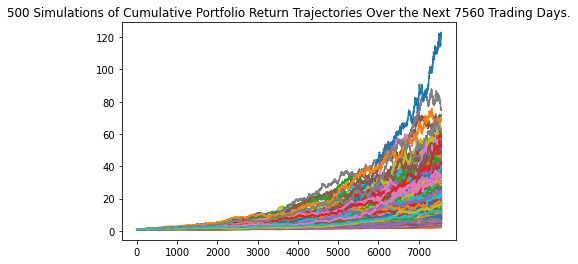

In [33]:
# Plot simulation outcomes
MC_thirtyyear.plot_simulation()

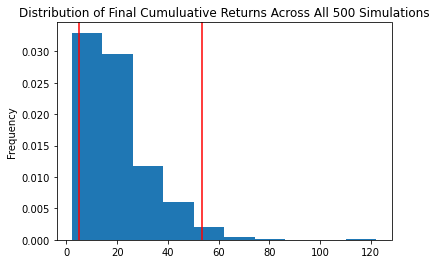

In [34]:
# Plot probability distribution and confidence intervals
dist_plot = MC_thirtyyear.plot_distribution()

### Retirement Analysis

In [35]:
# Fetch summary statistics from the Monte Carlo simulation results
mc_statistics = MC_thirtyyear.summarize_cumulative_return()

# Print summary statistics
print(mc_statistics)

count           500.000000
mean             20.378229
std              13.599444
min               2.138139
25%              11.025700
50%              16.774695
75%              25.929479
max             122.222181
95% CI Lower      4.871011
95% CI Upper     53.575074
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the 95% lower and upper confidence intervals based on a `$20,000` initial investment.

In [36]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(mc_statistics[8] * initial_investment,2)
ci_upper = round(mc_statistics[9] * initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $97420.23 and $1071501.47


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [37]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(mc_statistics[8] * initial_investment,2)
ci_upper = round(mc_statistics[9] * initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $146130.34 and $1607252.21


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [38]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
mc_fiveyear = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.30,.70],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [39]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
mc_fiveyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.989561,1.005062,0.998249,0.984004,1.010786,0.997958,0.996625,0.999616,0.998653,1.000892,...,0.988096,0.998632,0.983973,1.007817,1.007600,1.008715,1.000065,1.008623,0.996195,1.002745
2,0.982950,1.022329,1.003578,0.982669,1.014336,1.015945,0.987303,1.008919,0.998355,0.985947,...,0.990087,0.985381,0.994623,1.009309,0.997696,0.997606,1.013764,1.010318,0.997747,0.997835
3,0.965366,1.023447,0.988218,0.979085,1.004756,1.016846,0.991148,1.039170,1.004217,0.969108,...,0.994479,0.989964,0.998946,1.014781,0.995948,1.011886,1.027505,1.019375,0.998037,1.006259
4,0.966534,1.012058,0.995635,0.971327,0.996915,1.015888,0.974231,1.037454,1.021964,0.976326,...,0.995878,0.978622,0.993951,1.004482,1.000055,1.016394,1.027877,1.016510,1.004364,1.000414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.332509,0.880011,2.013755,2.526614,2.192858,1.626767,2.358903,1.976108,2.488952,1.347265,...,1.612294,1.853039,2.250919,2.183967,2.221619,2.640547,1.907388,2.450450,2.011452,1.850070
1257,1.312730,0.872660,1.989241,2.511296,2.190462,1.615982,2.338285,1.980870,2.491417,1.345672,...,1.626204,1.869237,2.264826,2.144273,2.215845,2.625359,1.889885,2.482857,2.014540,1.840644
1258,1.305364,0.875220,1.995231,2.503244,2.180927,1.627790,2.337529,1.970801,2.482722,1.323246,...,1.624734,1.888281,2.239608,2.126902,2.208868,2.647115,1.882233,2.487606,1.997011,1.851366
1259,1.297745,0.865587,2.003541,2.497104,2.211973,1.619107,2.336218,1.987682,2.497234,1.339197,...,1.638343,1.876544,2.231143,2.097515,2.197609,2.619876,1.894407,2.489541,1.987740,1.841664


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

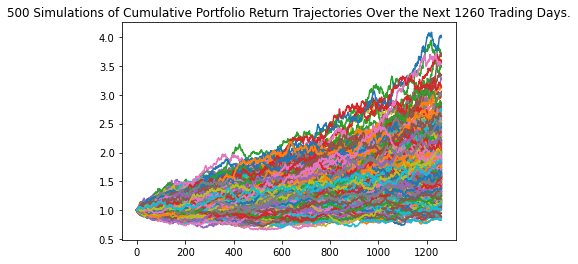

In [40]:
# Plot simulation outcomes
mc_fiveyear.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

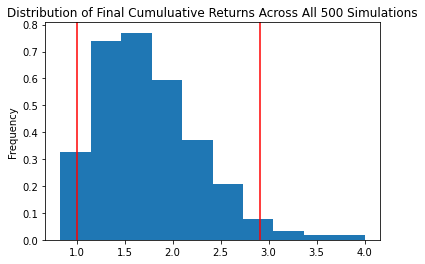

In [41]:
# Plot probability distribution and confidence intervals
mc_fiveyear.plot_distribution()

In [42]:
# Fetch summary statistics from the Monte Carlo simulation results
five_year_portfolio = mc_fiveyear.summarize_cumulative_return()

# Print summary statistics
print(five_year_portfolio)

count           500.000000
mean              1.751124
std               0.524869
min               0.831629
25%               1.373266
50%               1.642138
75%               2.042869
max               4.000329
95% CI Lower      1.007370
95% CI Upper      2.912462
Name: 1260, dtype: float64


In [43]:
# Set initial investment
initial_investment = 60000.00

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(five_year_portfolio[8] * initial_investment,2)
ci_upper_five = round(five_year_portfolio[9] * initial_investment,2)
# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000.0 in the portfolio over the next 5 years will end within in the range of $60442.2 and $174747.73


### Ten Years Retirement Option

In [44]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
mc_ten_year = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.30,.70],
    num_simulation = 500,
    num_trading_days = 252*10
)

In [45]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
mc_ten_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.004100,0.987769,0.998233,1.013515,1.012065,0.994942,0.994057,1.006758,0.994851,1.010649,...,0.991344,0.992963,0.993476,1.001257,0.999635,0.997928,0.991814,0.985944,1.002708,1.007203
2,1.016123,0.978695,0.999722,1.012073,1.008115,1.006614,0.992823,1.000651,0.993020,1.012466,...,0.998351,0.992979,1.016095,1.016425,0.993209,0.985027,1.001252,0.996918,1.005288,1.004388
3,1.024457,0.965749,0.994625,1.006477,1.000016,1.004652,1.005336,1.000234,0.998964,1.005773,...,0.992253,1.003381,1.026611,1.018428,1.009800,1.011620,0.995853,0.987472,1.000734,0.984847
4,1.033506,0.954967,0.991642,1.002783,1.003835,1.008702,0.999901,1.007134,0.997337,1.009540,...,0.980557,1.021993,1.009283,1.008329,1.020446,1.014415,1.013014,0.994787,0.985215,0.977228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,3.295795,1.491430,2.716366,1.635462,2.332900,2.050557,1.353844,3.522735,1.712672,3.138785,...,5.837219,6.313590,1.901214,3.022308,3.230264,2.747505,3.255660,3.724524,5.517659,1.244145
2517,3.296801,1.464947,2.698595,1.633718,2.341013,2.053673,1.365263,3.514912,1.702797,3.100638,...,5.885431,6.353279,1.886725,3.059158,3.225764,2.791288,3.214562,3.721407,5.556714,1.243605
2518,3.264078,1.486522,2.729222,1.648443,2.348947,2.025778,1.373214,3.552959,1.711199,3.090355,...,5.946489,6.427086,1.884123,3.030781,3.271772,2.771878,3.225493,3.750826,5.629731,1.254354
2519,3.283920,1.495687,2.709055,1.638056,2.341245,2.030128,1.389265,3.541644,1.734780,3.142435,...,5.979945,6.408182,1.888966,2.992701,3.299043,2.752654,3.209940,3.767995,5.574169,1.262664


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

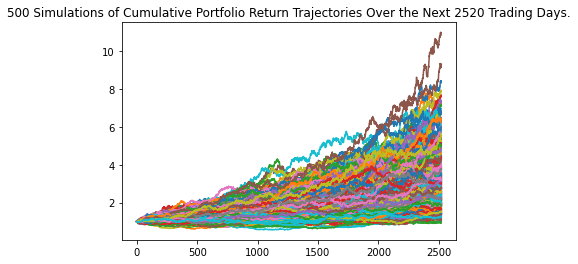

In [46]:
# Plot simulation outcomes
mc_ten_year.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

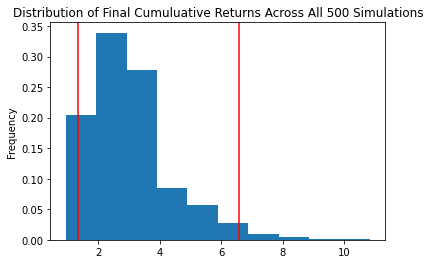

In [47]:
# Plot probability distribution and confidence intervals
mc_ten_year.plot_distribution()

In [48]:
# Fetch summary statistics from the Monte Carlo simulation results
ten_year_portfolio = mc_ten_year.summarize_cumulative_return()

# Print summary statistics
print(ten_year_portfolio)

count           500.000000
mean              3.041590
std               1.373926
min               0.933873
25%               2.075316
50%               2.778957
75%               3.541263
max              10.847083
95% CI Lower      1.336297
95% CI Upper      6.571347
Name: 2520, dtype: float64


In [49]:
# Set initial investment
initial_investment = 60000.00

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(ten_year_portfolio[8] * initial_investment,2)
ci_upper_ten = round(ten_year_portfolio[9] * initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000.0 in the portfolio over the next 10 years will end within in the range of $80177.81 and $394280.8
